In [1]:
colab = False

if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  import os
  os.chdir('/content/gdrive/My Drive/02460AdvancedML/Code/')
  
  #!git clone https://github.com/rtqichen/torchdiffeq.git
  !pip install -e torchdiffeq

In [2]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
from scipy.io import loadmat
from scipy.stats import multivariate_normal

from land.curve import *
from land.geodesics import *
from land.local_pca_metric import *
from IPython.display import Image
import random
import matplotlib.image as mpimg
import sys
from time import perf_counter
import multiprocessing
from functools import partial
from contextlib import contextmanager
import pickle
import gc
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

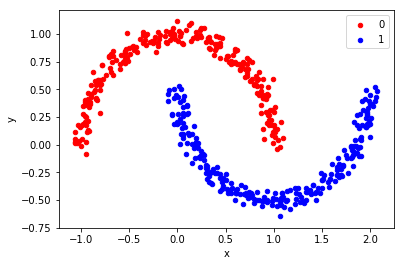

In [3]:

# generate 2d classification dataset
data,y = datasets.make_moons(noise=0.05, random_state=0,n_samples=500)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=data[:,0], y=data[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()
data = torch.tensor(data, dtype=torch.float)


In [4]:
N,D=data.shape

In [5]:
N

500

In [6]:
D

2

In [7]:
## Parameters for metric
sigma = 0.05 #0.1
rho = 0.1 #0.1

In [8]:
## Create metric
M = LocalVarMetric(data=data, sigma=sigma, rho=rho)

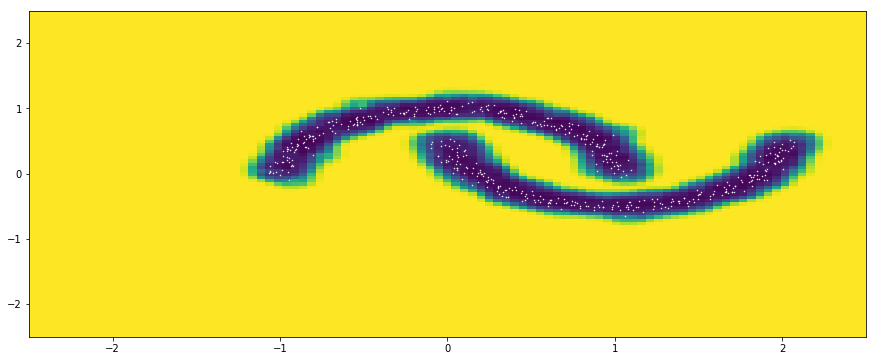

In [9]:
## Plot metric and data
f, axs = plt.subplots(1,1,figsize=(15,6));

ran = torch.linspace(-2.5, 2.5, 100)
X, Y = torch.meshgrid([ran, ran])
XY = torch.stack((X.flatten(), Y.flatten()), dim=1) # 10000x2
gridM = M.metric(XY) # 10000x2
Mim = gridM.sum(dim=1).reshape((100, 100)).detach().numpy().T
plt.pcolor(ran, ran, Mim)
plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), 'w.', markersize=1)
## Compute a curve energy
#for k in range(20):
#    p0 = data[torch.randint(high=N, size=[1], dtype=torch.long)].reshape((1, D))
#    p1 = data[torch.randint(high=N, size=[1], dtype=torch.long)].reshape((1, D))
#    #C = QuadraticCurve(begin=p0, end=p1, requires_grad=True)
#    #C = DiscreteCurve(begin=p0, end=p1, num_nodes=5, requires_grad=True)
#    C = CubicSpline(begin=p0, end=p1, num_nodes=5, requires_grad=True)
#    geodesic_minimizing_energy(C, M)
#    C.plot()

#p = torch.tensor([0.1, 0.35]).reshape(2, 1)
#v = torch.tensor([5.0, 0.0]).reshape(2, 1)
#c, dc = shooting_geodesic(M, p, v)
#plt.plot(c[:, 0].numpy(), c[:, 1].numpy())
plt.show()

In [10]:
def ExpMap(M,p,v):
    c = shooting_geodesic(M,p,v)[0]
    return c[-1].reshape(1, D)

In [11]:
def LogMap(p,q, num_nodes=10):
    C = CubicSpline(begin=p, end=q, num_nodes=num_nodes, requires_grad=True)
    geodesic_minimizing_energy(C, M)
    t = torch.linspace(0, 1, 2, dtype=C.begin.dtype)
    return C.deriv(t)[0].detach(),C

In [12]:
# tried both threading and multiprocessing -> mulit-processing is much faster
cpus = multiprocessing.cpu_count()

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

def calc_m(mu, v):
    # M is called to evaluate the metric --> gives the diagonal entries of the metric
    # The determinant of a diagonal matrix is the product of the values along the diagonal 
    #take mu as starting point, vector v as dirction, see where we end up, evaluate the curvature(metric) at the endpoint
    p = ExpMap(M, mu, v) 
    return M.metric(p).prod().sqrt() #returns scalar
    
'''def estimate_C(mu, Sigma, S=30, v_s=None):
    #print("Estimating for S: "+str(S))
    # 1.: random samples from a Euclidean normal distribution with zero mean and covariance matrix Sigma
    if v_s is None:
        #v_s = torch.Tensor(np.random.multivariate_normal((0,0), Sigma, S)).reshape(S, D) #shape([S, 2])
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu, covariance_matrix=Sigma)
        v_s = [mvn.sample() for s in range(S)]
    Z = math.sqrt(((2*math.pi)**D)*torch.det(Sigma))

    #2./3.: Compute C using m(mu,v)
    # parallelisation
    cpus = multiprocessing.cpu_count()
    with poolcontext(processes=cpus) as pool:
        m_s = pool.map(partial(calc_m, mu), v_s)

    C_hat = Z/S * sum(m_s)

    return C_hat
'''
def estimate_C(mu, Sigma, S=1000, v_s=None):
    #print("Estimating for S: "+str(S))
    # 1.: random samples from a Euclidean normal distribution with zero mean and covariance matrix Sigma
    if v_s is None:
        mvn=torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.tensor([0.0,0.0]), covariance_matrix=Sigma)        
        v_s = [mvn.sample() for s in range(S)]

    #2./3.: Compute C using m(mu,v)
    # parallelisation
    with poolcontext(processes=cpus) as pool:
        m_s = pool.map(partial(calc_m, mu), v_s)

    Z = math.sqrt(((2*math.pi)**D)*torch.det(Sigma))

    C_hat = Z/S * sum(m_s)

    return C_hat

In [13]:
def calc_objective(mu, Sigma, C, datasamples=500):

    for n in random.sample(range(0,N),datasamples):
        L1 = LogMap(mu,data[n])[0]
        L2 = torch.mv(torch.inverse(sigma), L1)
    LL += torch.dot(L1,L2) 
  
    phi = (LL/(2*datasamples)) + math.log(estimate_C(mu, sigma, S=50))
  
    return phi

In [14]:
''' 
def mu_step(mu, Sigma, C, v_s,respons,responsSum, alpha=0.01, data_samples=50):
    
    Z = math.sqrt(((2*math.pi)**D)*torch.det(Sigma))

    
    e1 = torch.sum(torch.stack([respons[n]*LogMap(mu, data[n]) for n in random.sample(range(0, N), data_samples)]), dim=0)
    e2 = Z *responsSum/ (C*S) * torch.sum(torch.stack([calc_m(mu, v)*v for v in v_s]), dim = 0)
     
    #omit denominator because we do steepest descent instead of gradient descent. The covariance matrix is poorly estimated and mu is heavily reliant ont it. 
    #sgmnv = - torch.inverse(torch.tensor(Sigma,dtype=torch.float))
   
    #nabla = torch.mv(sgmnv, e1-e2)
    nabla = e1-e2
    
    mu_p1 = ExpMap(M, mu, alpha*nabla)

    return mu_p1
 '''
def mu_step(mu, Sigma, C, v_s,respons,responsSum, alpha=0.01, data_samples=50):
    
    Z = math.sqrt(((2*math.pi)**D)*torch.det(Sigma))

    term1 = torch.sum(torch.stack([respons[n]*LogMap(mu, data[n])[0] for n in random.sample(range(0, N), data_samples)]), dim=0)
    term2 = Z *responsSum/ (C*S) * torch.sum(torch.stack([calc_m(mu, v)*v for v in v_s]), dim = 0)
    

    #omit denominator because we do steepest descent instead of gradient descent. The covariance matrix is poorly estimated and mu is heavily reliant ont it. 
    #sgmnv = - torch.inverse(torch.tensor(Sigma,dtype=torch.float))

    #nabla = torch.mv(sgmnv, term1-term2)
    nabla = term1-term2

    mu_p1 = ExpMap(M, mu, alpha*nabla)

    return mu_p1

In [15]:
'''def Sigma_step(mu, A, Sigma, C, v_s,respons,responsSum, alpha=0.01, data_samples=50):
    
    # equation (12) ------------------------------------------------------------
    # --- term1 ---
    loglist =[]
    for n in random.sample(range(0,N),data_samples):
        v = LogMap(mu,data[n])  
        loglist.append(torch.ger(v, v)*respons[n])
    term1 = torch.sum(torch.stack(loglist),dim=0)
    
    # --- term2 ---
    Z = math.sqrt(((2*math.pi)**D)*torch.det(Sigma)) # calculate Z w.r.t. Sigma
    term2 = ((Z*responsSum) / (C*S)) * torch.sum(torch.stack([calc_m(mu, v)*torch.ger(v,v) for v in v_s]), dim = 0)
    
    # compute gradient of A (line 7)
    grad = torch.mm(A, term1-term2)
   
    # compute new A (line 8) ---------------------------------------------------                       
    A_p1 = A - (alpha * grad)     
     
    # compute new Sigma (line 9) -----------------------------------------------
    Sigma_p1 = torch.inverse(torch.mm(A_p1.transpose(0,-1), A_p1))
    
    return A_p1,Sigma_p1
'''
def Sigma_step(mu, A, Sigma, C, v_s, respons,responsSum,alpha=0.01, data_samples=50):
    
    # equation (12) ------------------------------------------------------------
    # --- term1 ---
    loglist =[]
    for n in random.sample(range(0,N),data_samples):
        v = LogMap(mu,data[n])[0]   
        loglist.append(torch.ger(v, v)*respons[n])
    term1 = torch.sum(torch.stack(loglist),dim=0)
    
    # --- term2 ---
    Z = math.sqrt(((2*math.pi)**D)*torch.det(Sigma)) # calculate Z w.r.t. Sigma
    #term2 = (Z*responsSum / (C*S)) * torch.sum(torch.stack([calc_m(mu, v)*torch.mm(v,v.t()) for v in v_s]), dim = 0)
    term2 = (Z*responsSum / (C*S)) * torch.sum(torch.stack([calc_m(mu, v)*torch.ger(v.reshape(2),v.reshape(2)) for v in v_s]), dim = 0)
    # compute gradient of A (line 7)
    grad = torch.mm(A, term1-term2)
   
    # compute new A (line 8) ---------------------------------------------------                       
    A_p1 = A - (alpha * grad)     
     
    # compute new Sigma (line 9) -----------------------------------------------
    Sigma_p1 = torch.inverse(torch.mm(A_p1.transpose(0,-1), A_p1))
    
    return A_p1,Sigma_p1

init values with emgmm

In [16]:
def plot_normal(mu, Sigma):
#def plot_normal(mu, Sigma,marker,clr):
    l, V = np.linalg.eigh(Sigma)
    l[l<0] = 0
    t = np.linspace(0.0, 2.0*np.pi, 100)
    xy = np.stack((np.cos(t), np.sin(t)))
    Txy = mu + ((V * np.sqrt(l)).dot(xy)).T
    #plt.plot(Txy[:, 0], Txy[:, 1],marker,color=clr)
    plt.plot(Txy[:, 0], Txy[:, 1])

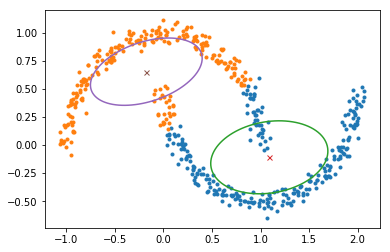

In [18]:
## Initialize parameters
K = 2; # try with different parameters
mu = []
Sigma = []
pi_k = np.ones(K)/K 
for _ in range(K):
  # Let mu_k be a random data point:
  mu.append(data[np.random.choice(N)])
  # Let Sigma_k be the identity matrix:
  Sigma.append(np.eye(D))

## Loop until you're happy
max_iter = 20; # XXX: you should find a better convergence check than a max iteration counter
log_likelihood = np.zeros(max_iter)
respons = np.zeros((K, N)) # KxN
for iteration in range(max_iter):
  ## Compute responsibilities
  # XXX: FILL ME IN!
  for k in range(K):
    respons[k] = pi_k[k] * multivariate_normal.pdf(data, mean=mu[k], cov=Sigma[k])
  respons /= np.sum(respons, axis=0)
  
  ## Update parameters
  # XXX: FILL ME IN!
  for k in range(K):
    respons_k = respons[k] # N
    Nk = np.sum(respons_k) # scalar
    mu[k] = respons_k.dot(data) / Nk # D
    delta = data.numpy() - mu[k] # NxD
    Sigma[k] = (respons_k * delta.T).dot(delta) / Nk # DxD
    pi_k[k] = Nk/N
  
  ## Compute log-likelihood of data
  #log_likelihood[iteration] = -1 # XXX: DO THIS CORRECTLY
  L = 0
  for k in range(K):
    L += pi_k[k] * multivariate_normal.pdf(data, mean=mu[k], cov=Sigma[k])
  log_likelihood[iteration] = np.sum(np.log(L))
  ## Plot data
cluster1 = torch.tensor([d.numpy() for i,d in enumerate(data) if respons[0][i]>respons[1][i]])
cluster2 = torch.tensor([d.numpy() for i,d in enumerate(data) if respons[0][i]<respons[1][i]])
## Plot data
plt.figure(1)
if D == 2:
    #plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.')
    plt.plot(cluster1[:, 0].numpy(), cluster1[:, 1].numpy(), '.')
    plt.plot(cluster2[:, 0].numpy(), cluster2[:, 1].numpy(), '.')
    
if D == 3:
    plt.plot3(X[:, 0], X[:, 1], X[:, 2], '.')

for k in range(K):
    plot_normal(mu[k], Sigma[k])
    plt.plot(mu[k][0], mu[k][1], 'x', markersize = 5)



#plt.show()


#plt.show()
mu_init = mu
Sigma_init=Sigma


In [ ]:
assert len(cluster1)+len(cluster2)==N

In [ ]:
#respons /= np.sum(respons, axis=0)
respons/=np.sum(respons,axis=0)

In [19]:
Sigma_init

[array([[0.36451392, 0.0332036 ],
        [0.0332036 , 0.10577952]]), array([[0.33160298, 0.06829695],
        [0.06829695, 0.09000438]])]

In [20]:
mu_init

[array([ 1.09065746, -0.10870713]), array([-0.17696738,  0.65449996])]

## Core algorithm

In [26]:
#add very small number to the result to make it a float if it is not working with numpy funcitons
def p_n(mu,Sigma,C,data):
    print("p_n_start")
    p=[]
    for x in data:
        term1 = LogMap(mu,x)[0]
        term2 = torch.mv(torch.inverse(Sigma), term1)
        dot = torch.dot(term1,term2)
        #temp = 1/C*math.exp(-0.5*dot)
        # print("temp "+str(temp)+ " term1 "+str(term1)+ " term2 "+str(term2))
          
        #p.append(temp.numpy())
        p.append(1/C*torch.exp(-0.5*dot))
        #print(p)
    p= np.stack(p,axis=0)
    return np.nan_to_num(p)

    

In [27]:
def initA(Sigma):
  Sig_inv = torch.inverse(Sigma)
  eigen = torch.symeig(Sigma, eigenvectors=True)
  V = eigen[1]
  V_t = torch.t(V)
  D = torch.tensor([[eigen[0][0], 0.0],[0.0, eigen[0][1]]])
  D_inv = torch.inverse(D)
  D_half_inv = torch.inverse(D**0.5)

  # Check that Sig_inv and reconstructed s_inv are the same:
  sig_inv = torch.mm(V, torch.mm(D_inv, V_t))
  A_t = torch.mm(V, D_half_inv)
  A = torch.t(A_t)
  return A
def initSigma(mu,cluster):
  #only with points in cluster...
  # initialise Sigma w.r.t. mu 
  mu = torch.tensor([[0.1518, 0.3105]]) #estimated mu
  logs_tensor = torch.empty(len(cluster), 2) # for pytorch

  for n in range(len(cluster)):
      logs_tensor[n] = LogMap(mu, cluster[n])[0]
    
  Sigma_estimate = sum([torch.ger(l,l) for l in logs_tensor])/(len(cluster)-1)
  return Sigma_estimate

In [28]:
def load_data(i=0,fp=""):
  C = pickle.load( open( fp+"C_"+str(i), "rb" ) )
  Sigma = pickle.load( open( fp+"Sigma_"+str(i), "rb" ) )
  mu = pickle.load( open( fp+"mu_"+str(i), "rb" ) )
  respons = pickle.load( open( fp+"respons_"+str(i), "rb" ) )
  A = pickle.load(open(fp+"A_"+str(i),"rb"))
  return C,Sigma,mu,respons,A



In [ ]:
# load data from previous fitting
alpha = 0.005
fp="results_mm/N500/"
counter = 24
C,Sigma,mu,respons,A=load_data(i=counter,fp=fp)
file_path = "results_mm/N500/data_halfmoon.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
data = pickle.loads(bytes_in)

K=2
pi_k = np.ones(K)/K
N,D=data.shape
## Parameters for metric
sigma = 0.05 #0.1
rho = 0.1 #0.1
## Create metric
M = LocalVarMetric(data=data, sigma=sigma, rho=rho)

for k in range(K):
    respons_k = respons[k] # N
    Nk = np.nansum(respons_k)
    pi_k[k] = Nk/N


#A=[]

#for i in range(K):
#    A.append(initA(Sigma[i]))
data_samples = 40




In [14]:
Nk

284.75221233695004

In [38]:
for i,k in enumerate(respons[0]):
  if math.isnan(k):
    print(i,k)

814 nan


In [29]:
#initial values
alpha = 0.005
S = 100
data_samples = 30 #50
ctr = 0
verbose = 1

K=2
#mu = [torch.tensor([[ 1.1892571 ,  0.03590373]]),torch.tensor([[-0.15778099,  0.44621062]])]
#mu = [torch.tensor([[-0.12898634,  0.43546987]]),torch.tensor([[ 1.2068827 ,  0.03277878]])]

#mu = [torch.tensor([m]) for m in mu_init]

#mu = [torch.as_tensor(np.array(m)).double() for m in mu_init]
#Sigma=[torch.tensor(s) for s in Sigma_init]
#Sigma = [torch.tensor([[ 0.47640275, -0.06581062],
#        [-0.06581062,  0.19106783]]), torch.tensor([[ 0.45643635, -0.05615405],
#        [-0.05615405,  0.18572768]])]
mu = [torch.tensor([[ 1.09065746, -0.10870713]]), torch.tensor([[-0.17696738,  0.65449996]])]
Sigma = [torch.tensor([[0.36451392, 0.0332036 ],
        [0.0332036 , 0.10577952]]), torch.tensor([[0.33160298, 0.06829695],
        [0.06829695, 0.09000438]])]
#cluster=[]
#fp="results_mm/new_C/"
#labels_ = pickle.load( open( fp+"labels_", "rb" ) )



#Sigma = []
C = []
A=[]
pi_k = np.ones(K)/K
for k in range(K):
    #mu.append(data[np.random.choice(N)])
    #cluster.append(torch.tensor([d.numpy() for i,d in enumerate(data) if labels_[i]==k]))
    #Sigma.append(initSigma(mu[i],cluster[k]))
    #Sigma.append(torch.eye(2)*0.25)
    C.append(estimate_C(mu[k], Sigma[k], S))
    A.append(initA(Sigma[k]))
#get init values mu,Sigma,C,pi_k for all cluster
counter = 0


file_path = "results_mm/N500/data_halfmoon.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
#data = bytearray(n_bytes)

## write
bytes_out = pickle.dumps(data)
with open(file_path, 'wb') as f_out:
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])
respons = np.zeros((K,N))

gc.collect()



5299

In [ ]:
data_samples = 50 #50


In [ ]:
alpha = 0.005

In [ ]:
counter =24

In [ ]:
max_iter = 100
log_likelihood = np.zeros(max_iter)
savepath="results_mm/N500/"
for iteration in range(max_iter):
    #mu_total.append(mu.copy())
    #C_total.append(C.copy())
    #Sigma_total.append(Sigma.copy())
    #respons_total.append(respons.copy())
    
    filehandler_1 = open(savepath+"mu_"+str(counter), 'wb')
    filehandler_2 = open(savepath+'C_'+str(counter), 'wb') 
    filehandler_3 = open(savepath+'Sigma_'+str(counter), 'wb') 
    filehandler_4 = open(savepath+'respons_'+str(counter), 'wb') 
    filehandler_5 = open(savepath+'A_'+str(counter), 'wb') 

    pickle.dump(mu, filehandler_1)
    pickle.dump(C.copy(), filehandler_2)
    pickle.dump(Sigma.copy(), filehandler_3)
    pickle.dump(respons.copy(), filehandler_4)
    pickle.dump(A.copy(), filehandler_5)

    filehandler_1.close()
    filehandler_2.close()
    filehandler_3.close()
    filehandler_4.close()
    filehandler_5.close()
    
    
    
    
    ##Debug area
    print("iter: "+str(counter))
    print("mu_"+str(counter)+"="+str([m.detach() for m in mu]))
    print("Sigma_"+str(counter)+"="+str([s.detach() for s in Sigma]))
    
    ##
    #Expectation step:
    for k in range(K):
        respons[k]=p_n(mu[k],Sigma[k],C[k],data)
        respons[k]=respons[k]*pi_k[k]
    respons = respons /np.sum(respons,axis=0)
    #Maximization step:
    for k in range(K):
        respons_k = np.nan_to_num(respons[k]) # N
        Nk = np.nansum(respons_k) # scalar
        print("Nk: {}".format(Nk))

        # random sample vectors
        S=60
    #        v_s = torch.Tensor(np.random.multivariate_normal((0,0), Sigma[k].detach(), S)).reshape(S, D) #shape([S, 2])
        # estimate C
    #       C[k] = estimate_C(mu[k].detach(), Sigma[k].detach(), S, v_s.detach())
        #print("C[k] "+str(C[k]))
    #        print('after C')
        # take Step
    #        mu_p1 = mu_step(mu[k], Sigma[k].detach(), C[k], v_s,respons_k,Nk)
        #update parameters
    # random sample vectors
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.tensor([[0.0,0.0]]), covariance_matrix=Sigma[k])
        v_s = [mvn.sample() for s in range(S)]
    
        # estimate C
        C[k] = estimate_C(mu[k], Sigma[k], S, v_s)
    
    # take Step
        mu_temp = mu_step(mu[k], Sigma[k], C[k], v_s,respons_k,Nk, alpha)
        mu[k] = mu_temp
        ######Fitting Sigma######
        # random sample vectors
        S=800
        print('S')
        #v_s = torch.Tensor(np.random.multivariate_normal((0,0), Sigma[k].detach(), S)).reshape(S, D) #shape([S, 2])
        #estimate C for updated mu
    #    C[k] = estimate_C(mu[k].detach(), Sigma[k].detach(), S, v_s.detach())
        #take Step
    #    A_p1,Sigma_p1 = Sigma_step(mu[k], A[k], Sigma[k], C[k], v_s,respons_k,Nk)
    # random sample vectors
        mvn = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.tensor([[0.0,0.0]]), covariance_matrix=Sigma[k])
        print('mvn')
        v_s = [mvn.sample() for s in range(S)]   
        print('v_s')
      #estimate C
        C[k] = estimate_C(mu[k], Sigma[k], S, v_s)
        print('C'+str(k))  
    
      #take Step
        A_p1,Sigma_p1 = Sigma_step(mu[k], A[k], Sigma[k], C[k], v_s,respons_k,Nk, alpha)
        print('A&Sigma')
        #update parameters
        A[k],Sigma[k]=A_p1,Sigma_p1
        
        pi_k[k] = Nk/N#
        gc.collect()

    counter+=1



iter: 0
mu_0=[tensor([[ 1.0907, -0.1087]]), tensor([[-0.1770,  0.6545]])]
Sigma_0=[tensor([[0.3645, 0.0332],
        [0.0332, 0.1058]]), tensor([[0.3316, 0.0683],
        [0.0683, 0.0900]])]
p_n_start
p_n_start
Nk: 186.92648462176464
S
mvn
v_s
C0
A&Sigma
Nk: 313.07351537823536
S
mvn
v_s
C1
A&Sigma
iter: 1
mu_1=[tensor([[ 1.0500, -0.1212]]), tensor([[-0.1862,  0.6708]])]
Sigma_1=[tensor([[0.1966, 0.0111],
        [0.0111, 0.0981]]), tensor([[0.1389, 0.0180],
        [0.0180, 0.0646]])]
p_n_start
p_n_start
Nk: 176.62520949637883
S
mvn
v_s
C0
A&Sigma
Nk: 323.37479050362117
S
mvn
v_s
C1
A&Sigma
iter: 2
mu_2=[tensor([[ 1.0683, -0.1799]]), tensor([[-0.2271,  0.6053]])]
Sigma_2=[tensor([[0.1386, 0.0082],
        [0.0082, 0.0837]]), tensor([[0.0946, 0.0045],
        [0.0045, 0.0528]])]
p_n_start
p_n_start
Nk: 237.5666881254582
S
mvn
v_s
C0
A&Sigma
Nk: 262.4333118745418
S
mvn
v_s
C1
A&Sigma
iter: 3
mu_3=[tensor([[ 1.0903, -0.2244]]), tensor([[-0.3113,  0.6435]])]
Sigma_3=[tensor([[0.1020, 0.005

/Users/ek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


S
mvn
v_s
C0
A&Sigma
Nk: 245.26961597177316


In [19]:
p_n(mu[0],Sigma[0],C[0],data[:5])
    #respons[k]=respons[k]*pi_k[k]
#respons /= np.sum(respons,axis=0)

p_n_start


array([3.2019781e-08, 1.1946927e-04, 7.8077770e-27, 8.4039653e-05,
       9.5319754e-01], dtype=float32)

In [37]:
respons

array([[9.99985313e-01, 1.20781861e-04, 3.08701529e-18, ...,
        6.12878481e-01, 8.71666186e-06, 9.90484353e-01],
       [1.46872799e-05, 9.99879218e-01, 1.00000000e+00, ...,
        3.87121519e-01, 9.99991283e-01, 9.51564728e-03]])

In [ ]:
test = [0 if math.isnan(i) else i for i in respons[0]]

In [ ]:
  ## Plot log-likelihood -- did we converge?
#plt.figure(1)
#plt.plot(log_likelihood)
#plt.xlabel('Iterations')
#plt.ylabel('Log-likelihood')

## Plot data
plt.figure(1,figsize=(15,6))
if D == 2:
    plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.')
if D == 3:
    plt.plot3(X[:, 0], X[:, 1], X[:, 2], '.')

#for k in range(K):
#    plot_normal(mu[k], Sigma[k])
colors = ['maroon','red','darkmagenta','indigo','blue','navy','C7','C8','C9','C9','C9','C9','C9','C9','C9','C9']

for k in range(K):
  for idx,m in enumerate(mu_total):
        print(m[0].detach().numpy(),m[1].detach().numpy())
        mu1=m[0].detach().numpy()
        mu2=m[1].detach().numpy()
        if len(mu1)==1:
          mu1=mu1[0]
          mu2=mu2[0]
        plt.plot(mu1[0],mu1[1], 'x', markersize = 5,color=colors[idx])
        plt.plot(mu2[0],mu1[1], 'x', markersize = 5,color=colors[idx])

          
        #print(mu[idx][k].reshape(2,1).detach())
        #plot_normal(mu[idx][k].reshape(2,1).detach(),Sigma_total[idx][k].detach())



plt.show()

NameError: ignored

In [ ]:
Sigma_total

In [ ]:
def plot_normal(mu_tensor, Sigma,prec=150):
    l, V = np.linalg.eigh(Sigma)
    mu=mu_tensor.reshape(1, 2).numpy()
    l[l<0] = 0
    t = np.linspace(0.0, 2.0*np.pi, prec)
    xy = np.stack((np.cos(t), np.sin(t)))
    Txy = mu + ((V * np.sqrt(l)).dot(xy)).T
    plt.plot(Txy[:, 0], Txy[:, 1])

In [ ]:
mu_total

NameError: ignored

In [ ]:
'''
Getting data for plotting ellipses
prec - precission factor of the plot
p - error factor
'''
def normal_LAND(mu_tensor, Sigma,p=1,prec = 150):
    print("normal_Land: p="+str(p))
    l, V = np.linalg.eigh(Sigma*p)
    mu=mu_tensor.reshape(1, 2).numpy()
    l[l<0] = 0
    t = np.linspace(0.0, 2.0*np.pi, p*prec)
    xy = np.stack((np.cos(t), np.sin(t)))
    Txy = mu + ((V * np.sqrt(l)).dot(xy)).T
    LAND_Txy = np.array([ExpMap(M,mu_tensor,torch.tensor([i[0],i[1]]).reshape(2,1)-mu_tensor)[0].numpy() for i in Txy])
    
    return LAND_Txy






In [ ]:
S=10
mvn = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu[k], covariance_matrix=Sigma[k])
v_s = [mvn.sample().detach() for s in range(S)]
for v in v_s:
  print(v[0][0])

tensor(0.3330)
tensor(0.3852)
tensor(-0.5475)
tensor(-0.3760)
tensor(-0.1007)
tensor(0.2290)
tensor(0.2355)
tensor(-0.2315)
tensor(-0.2189)
tensor(-0.0789)


In [ ]:
v_s = torch.Tensor(np.random.multivariate_normal((0,0), Sigma[k].detach(), S)).reshape(S, D) #shape([S, 2])
v_s

tensor([[ 0.3354, -0.1834],
        [ 0.0307, -0.0614],
        [-0.1269, -0.0754],
        [ 0.2658,  0.0404],
        [-0.1135,  0.0385],
        [ 0.1438,  0.1078],
        [-0.7317, -0.1070],
        [-0.0530,  0.0276],
        [-0.3147,  0.0472],
        [-0.2689,  0.1014]])

In [ ]:
def plot_normal_LAND(mu,X,K,respons,saveName=None):
    #f, axs = plt.subplots(1,1,figsize=(20,14));
    f, axs = plt.subplots(1,1,figsize=(20,10));

    #Plot original data
    plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.',color='royalblue', markersize=7)
    #Plot mu
    for k in range(K):
        plt.plot(mu[k][0], mu[k][1], 'cD', markersize = 10)
        #Plot ellipse from co  variance matrix and error values
        colors = ['maroon','red','darkmagenta','indigo','blue','navy','C7','C8','C9']
        for idx,i in enumerate(X[k]):
            plt.fill(i[:, 0], i[:, 1],'x',color=colors[0],alpha=1-idx/len(X[k]))#,markersize=4)

    #plt.xlim([-2,2])
    lgd_list=['data']
    lgd_list.extend(['$\mu_'+str(k)+'$' for k in range(K)])
    lgd_list.extend(['$1\sigma$','$2\sigma$','$3\sigma$','$4\sigma$','$5\sigma$','$6\sigma$'])
    plt.legend(lgd_list)
    plt.xlim([-1.1,2.3]);
    plt.ylim([-0.7,1.3]);
    if saveName != None:
        plt.savefig(saveName+".png")




In [ ]:
'''
provide function with:
mu - mean value of the LAND fitting
Sigma - Sigma value of the LAND fitting as torch.tensor
error - False no error ellipses are plotted
define -  error range 2=2*sigma, 3=3*sigma as np.arange()
---np.arange(2,10,2)
'''
def get_data_for_plot_normal_LAND(mu,Sigma,error=False,errorRange=None,prec=150):

    X=[]
    X.append(normal_LAND(mu,Sigma.numpy()))
    if error:
        for p in errorRange:
            #print("current p"+str(p))
            X.append(normal_LAND(mu,Sigma.numpy(),p,prec))
    return X





In [ ]:
'''
Getting data for plotting ellipses
prec - precission factor of the plot
p - error factor
'''
def normal_LAND(mu_tensor, Sigma,p=1,prec = 150):
    print("normal_Land: p="+str(p))
    l, V = np.linalg.eigh(Sigma*p)
    mu=mu_tensor.reshape(1, 2).numpy()
    l[l<0] = 0
    t = np.linspace(0.0, 2.0*np.pi, p*prec)
    xy = np.stack((np.cos(t), np.sin(t)))
    Txy = mu + ((V * np.sqrt(l)).dot(xy)).T
    LAND_Txy = np.array([ExpMap(M,mu_tensor,torch.tensor([i[0],i[1]]).reshape(2,1)-mu_tensor)[0].numpy() for i in Txy])
    
    return LAND_Txy




In [ ]:
def calc_objective(mu, Sigma,respons, C=None, datasamples=200, S=1000):
    
    LL=0
    for k in range(K):
        responsSum = np.sum(respons[k])
        pi_k=responsSum/N
        for n in random.sample(range(0,N),datasamples):
            L1 = LogMap(mu[k],data[n])[0]
            L2 = torch.mv(torch.inverse(Sigma[k]), L1)
            
            LL += respons[k][n]*((torch.dot(L1,L2).detach()/2)+math.log(C[k])-math.log(pi_k))

         #if C is None:
        #    C = estimate_C(mu, Sigma, S)
   
        
    
  
    return LL

In [ ]:
#read objective from file
file_path = "results_mm/sigma_0.04_rho_0.3/objective.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
ob = pickle.loads(bytes_in)

In [ ]:
ob

[tensor(929.9241),
 tensor(864.3823),
 tensor(866.5539),
 tensor(818.8414),
 tensor(718.1504),
 tensor(724.2941),
 tensor(762.1197),
 tensor(1486.2567),
 tensor(1539.0560),
 tensor(1445.9833),
 tensor(1411.5049),
 tensor(1458.7961),
 tensor(1597.7986),
 tensor(1954.4967),
 tensor(1260.4568),
 tensor(1519.6656),
 tensor(1180.4967),
 tensor(1336.6504),
 tensor(1259.8549),
 tensor(1261.9470),
 tensor(1407.3639),
 tensor(1654.3090),
 tensor(1564.6814),
 tensor(1512.8551),
 tensor(1877.3712),
 tensor(1621.9033),
 tensor(1350.6588),
 tensor(1246.6322),
 tensor(1585.6926),
 tensor(1025.0747),
 tensor(1276.4177),
 tensor(1689.0597),
 tensor(1524.2606),
 tensor(1374.3962),
 tensor(1380.2043),
 tensor(1467.2919),
 tensor(2228.0891),
 tensor(2060.4390),
 tensor(1318.0366),
 tensor(1360.7562),
 tensor(1597.7357),
 tensor(1145.5831),
 tensor(1612.9017),
 tensor(1229.4166),
 tensor(1340.6642),
 tensor(2315.8293),
 tensor(1337.7596)]

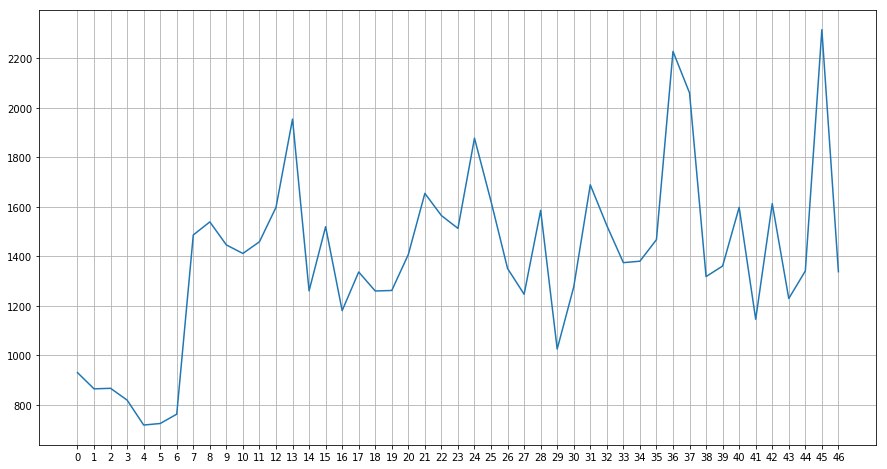

In [ ]:
f, axs = plt.subplots(1,1,figsize=(15,8));

plt.plot([i for i in range(len(ob))],[ob[i] for i in range(len(ob))]);
axs.set_xticks([i for i in range(len(ob))])
plt.grid()

plt.show()

In [ ]:
respons

NameError: ignored